# Deepwalk-HPP

Deepwalk-HPP is a Python repository that implements house representation learning using DeepWalk, a network representation learning technique.

## M. Amintoosi

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx  
from scipy.spatial.distance import pdist, squareform  
from tqdm import tqdm  
from pyproj import Transformer, CRS  
# import seaborn as sns
# import regex as re

# from sklearn.neighbors import KernelDensity
# pd.options.display.max_columns = None
# from sklearn import preprocessing

In [2]:

from sklearn.model_selection import train_test_split #, cross_validate 
# from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression #, Ridge  , LogisticRegression , QuantileRegressor
from sklearn.ensemble import GradientBoostingRegressor # , RandomForestRegressor , HistGradientBoostingRegressor 
from sklearn.metrics import mean_absolute_percentage_error , r2_score, mean_squared_error
# from xgboost import XGBRegressor
# from geopy.geocoders import Nominatim
# from concurrent.futures import ThreadPoolExecutor

###########################################################################################################################
from gensim.models import Word2Vec
# from gensim.scripts.glove2word2vec import glove2word2vec
# from gensim.models import KeyedVectors
# import re
# from sklearn.decomposition import PCA
# from matplotlib import pyplot as plt
# from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import json
import plotly.express as px
import networkx as nx
from geopy.distance import geodesic
from scipy.spatial import cKDTree

In [3]:
# !pip install nodevectors

# Load the real estate dataset for Mashhad, Iran

In [4]:
data= pd.read_excel('Mashhad_Real_Estate_Data.xlsx')
data.head()

,type,area_sq_m,latitude,longitude,age_years,floor_number,number_of_bedrooms,price,region,elevator,...,stone_façade,garden,direction,furnished,renovated,closet,em_mos,naghashi,property_document_type,utilities_included
0,0,73.0,36.373776,59.475820,11,1,2,2200000000,12,1,...,0,0,0,0,0,0,0,0,1,4
1,0,100.0,36.327670,59.548380,7,1,2,4800000000,2,1,...,0,0,0,0,0,0,0,0,0,3
2,0,140.0,36.310605,59.504477,0,2,2,10200000000,9,1,...,0,1,1,0,0,0,0,0,1,4
3,0,65.0,36.400540,59.388382,6,4,1,870000000,12,0,...,0,0,0,0,0,1,1,1,2,0
4,0,200.0,36.373776,59.475820,0,0,3,5350000000,12,1,...,0,0,1,0,0,0,0,0,1,4


In [5]:
data.columns

Index(['type', 'area_sq_m', 'latitude', 'longitude', 'age_years',
       'floor_number', 'number_of_bedrooms', 'price', 'region', 'elevator',
       'parking', 'storage', 'shop_or_space', 'balcony', 'full_amenities',
       'parquet', 'ceramic_flooring', 'stone_façade', 'garden', 'direction',
       'furnished', 'renovated', 'closet', 'em_mos', 'naghashi',
       'property_document_type', 'utilities_included'],
      dtype='object')

In [6]:
data.shape

(44781, 27)

In [7]:
# Check if there are any NaN values in the DataFrame
has_nan = data.isnull().any().any()
print(has_nan)  # True if there are any NaN values

False


## Filter the data to focus on properties within a specific geographic region of Mashhad
### The latitude and longitude ranges likely correspond to the city's central or most relevant area

In [8]:
filtered_data = data[(data['longitude'] >= 59.45) & (data['longitude'] <= 59.7) & 
                 (data['latitude'] >= 36.2) & (data['latitude'] <= 36.4)]
filtered_data.shape

(44670, 27)

Randomly sample 10,000 data points from the filtered dataset

This creates a smaller, manageable dataset for analysis while maintaining diversity and reducing potential bias from any inherent order in the original data

In [9]:
np.random.seed(42)
shuffle_indices = np.random.choice(np.arange(filtered_data.shape[0]), size=10000, replace=False,)
df = filtered_data.iloc[shuffle_indices].reset_index(drop=True)
len(df) #, df.head(2)

10000

Visualize the spatial distribution of the selected properties using a scatter plot

In [10]:
import plotly.express as px
px.scatter(df , x="longitude", y="latitude",  width=400, height=400)#.write_image("img/spatial_distribution.png")

Creates a NetworkX graph of houses in Mashhad

In [11]:
import numpy as np  
import pandas as pd  
import networkx as nx  
from pyproj import CRS, Transformer  
from scipy.spatial.distance import pdist, squareform  
from tqdm import tqdm  # For progress bar  

def create_mashhad_house_graph(df, distance_threshold_meters=200):  
    """  
    Creates a NetworkX graph of houses in Mashhad, using UTM projection.  

    Args:  
        df: Pandas DataFrame with 'latitude', 'longitude', and 'type' columns.  
        distance_threshold_meters: Maximum distance (in meters) between houses to be connected.  

    Returns:  
        A NetworkX graph, or None if an error occurs.  
    """  
    # Define input and output CRS (Coordinate Reference Systems)  
    in_crs = CRS.from_epsg(4326)  # WGS 84 (lat/long)  
    out_crs = CRS.from_epsg(32640)  # UTM zone 40N  

    transformer = Transformer.from_crs(in_crs, out_crs, always_xy=True)  

    # Initialize an empty graph  
    G = nx.Graph()  

    # Transform coordinates to UTM  
    coords_utm = np.array([transformer.transform(lon, lat) for lat, lon in zip(df['longitude'], df['latitude'])])  # longitude, then latitude  

    # Calculate Euclidean distances in meters  
    distances = squareform(pdist(coords_utm))  

    # Add nodes to the graph with their respective attributes from the DataFrame  
    nodes = {}  
    for index, row in df.iterrows():  
        G.add_node(index, pos=(row['latitude'], row['longitude']), Type=row['type'])  # Adjust attributes if needed  
        nodes[index] = len(nodes)  

    # Create edges based on the distance threshold  
    num_houses = len(nodes)  
    node_list = list(nodes.keys())  
    for i in tqdm(range(num_houses), desc="Building graph"):  
        for j in range(i + 1, num_houses):  
            index1 = node_list[i]  
            index2 = node_list[j]  
            if distances[i, j] <= distance_threshold_meters:  
                G.add_edge(index1, index2, weight=distances[i, j])  

    return G

# Example usage:  
# df = pd.DataFrame({...})  # Your DataFrame with required columns  
# graph = create_mashhad_house_graph(df, distance_threshold_meters=500)  
# print(f"Number of edges in the graph: {graph.number_of_edges()}")

In [12]:
# Example usage  
G = create_mashhad_house_graph(df)  
num_edges = G.number_of_edges()  
print(f"Number of edges in the graph: {num_edges}")
for node in list(G.nodes(data=True))[:5]:  # Display the first 5 nodes and their attributes  
    print(node)

Building graph: 100%|██████████| 10000/10000 [00:17<00:00, 561.33it/s]


Number of edges in the graph: 2756904
(0, {'pos': (36.290244424527, 59.507193767606), 'Type': 0.0})
(1, {'pos': (36.36002, 59.5174), 'Type': 0.0})
(2, {'pos': (36.32581, 59.58692), 'Type': 0.0})
(3, {'pos': (36.31845, 59.58768), 'Type': 0.0})
(4, {'pos': (36.30685, 59.57511), 'Type': 1.0})


In [13]:
# nx.write_sparse6(G, "mashhad_graph.s6")

In [14]:
# G = nx.read_sparse6("mashhad_graph.s6")

## Function: Fit and Evaluate a Regression Model

This function takes a regression model and training/testing data as input, fits the model, and evaluates its performance using several metrics. Here's a breakdown:

*   **Model Fitting:** The function first fits the provided `model` to the training data (`X_train`, `y_train`). This step involves the model learning patterns from the training data to make predictions.
*   **Predictions:** It then uses the fitted model to predict the target variable (`y_pred`) for the test data (`X_test`).
*   **Performance Evaluation:** The function calculates several metrics to assess the model's performance:
    *   **R-squared (R2):** Measures the proportion of variance in the target variable explained by the model. Higher R2 values indicate better fit. 
    *   **Mean Absolute Percentage Error (MAPE):** Measures the average percentage difference between the predicted and actual values. Lower MAPE values indicate better accuracy.
    *   **Mean Squared Error (MSE):** Measures the average squared difference between the predicted and actual values. Lower MSE values indicate better accuracy.
    *   **Range Accuracy:** This metric is defined within the function. It calculates the proportion of predictions that fall within a certain tolerance range of the actual values. The tolerance is set by the `tolerance` parameter (default is 0.2, or 20%). 
*   **Visualization:** The function creates a scatterplot of the actual target values (`y_test`) against the predicted values (`y_pred`). This visualization helps to visually assess the model's performance and identify any potential patterns or outliers.

## Function: Random Walk in a Graph

This function performs a random walk on a graph `G`, starting from a given node `start` and continuing for a specified `length`. Here's a breakdown:

*   **Initialization:**
    *   `walk = [str(start)]`: The function initializes a list called `walk` to store the nodes visited during the walk. It starts by adding the `start` node to the list as a string.
*   **Iteration:**
    *   `for i in range(length):`: The function iterates `length` times, representing the steps in the random walk.
        *   `neighbors = [node for node in G.neighbors(start)]`: It gets a list of neighbors of the current node `start` from the graph `G`.
        *   `next_node = np.random.choice(neighbors, 1)`: It randomly selects one of the neighbors as the `next_node` using the `np.random.choice` function.
        *   `walk.append(str(next_node))`: The `next_node` is added to the `walk` list as a string.
        *   `start = next_node`: The `next_node` becomes the new `start` node for the next step in the walk.
*   **Return:**
    *   `return walk`: The function returns the `walk` list, which contains the sequence of nodes visited during the random walk.

In [15]:
def random_walk(start, length):
    walk = [str(start)]  # starting node
    
    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
    
    return walk

In [16]:
nx.is_connected(G)

False

After sampling the dataset, we created a graph of 10,000 properties for the random walk algorithm. To ensure applicability, the graph must be connected, so we identified the largest connected subgraph. The process for extracting this component is described below:

In [17]:
import networkx as nx

# Find the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph from the largest connected component
largest_subgraph = G.subgraph(largest_cc).copy()

# If you want to remove the disconnected nodes from the original graph
# G = largest_subgraph
# nx.is_connected(G)
nx.is_connected(largest_subgraph)

True

In [18]:
# Get the nodes in the largest connected component  
nodes_in_largest_cc = set(largest_subgraph.nodes())  

# Use boolean indexing to filter the DataFrame  
df_filtered = df[df.index.isin(nodes_in_largest_cc)] 

In [19]:
# Use the largest connected component graph  
# largest_subgraph = G.subgraph(largest_cc).copy()  

# You can now work with largest_subgraph for graph-related operations, such as:  
print(f"Number of nodes in the largest subgraph: {largest_subgraph.number_of_nodes()}")  
print(f"Number of edges in the largest subgraph: {largest_subgraph.number_of_edges()}")  

# And you can work with df_filtered for DataFrame-related operations:  
print(df_filtered.shape)

Number of nodes in the largest subgraph: 2262
Number of edges in the largest subgraph: 1949364
(2262, 27)


In [20]:
#Verify the number of rows:  
print(f"Original DataFrame shape: {df.shape}")  
print(f"Filtered DataFrame shape: {df_filtered.shape}")  
G.number_of_nodes(), G.number_of_edges(), \
largest_subgraph.number_of_nodes(), largest_subgraph.number_of_edges()

Original DataFrame shape: (10000, 27)
Filtered DataFrame shape: (2262, 27)


(10000, 2756904, 2262, 1949364)

In [21]:
px.scatter(df_filtered , x="longitude", y="latitude",  width=400, height=400)#.write_image("img/spatial_distribution.png")

In [22]:
# df_filtered.head(5)

In [23]:
G.nodes, largest_subgraph.nodes

(NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [24]:
%%time
from nodevectors import Node2Vec

# Test Graph
# G = nx.generators.classic.wheel_graph(100)

# Fit embedding model to graph
g2v = Node2Vec(
    n_components=3,
    walklen=10
)
# way faster than other node2vec implementations
# Graph edge weights are handled automatically
# g2v.fit(G)

# query embeddings for node 42
# g2v.predict(42)

CPU times: total: 391 ms
Wall time: 2 s


In [25]:
# g2v.save('var/node2vec')
# # You however need to specify the extension when reading it back
# # g2v = Node2Vec.load('var/node2vec.zip')

# # Save model to gensim.KeyedVector format
# g2v.save_vectors("var/wheel_model.bin")

# # load in gensim
# from gensim.models import KeyedVectors
# model = KeyedVectors.load_word2vec_format("var/wheel_model.bin")

In [26]:
n2v_embeddings = g2v.fit_transform(G)
n2v_embeddings.shape

c:\Users\m.amintoosi\.conda\envs\pth-gpu\lib\site-packages\networkx\linalg\graphmatrix.py:187: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



Making walks... Done, T=4.97
Mapping Walk Names... Done, T=1.27
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=26.04


(10000, 3)

In [28]:
# n2v_embeddings = g2v.fit_transform(largest_subgraph)
# n2v_embeddings.shape

In [29]:
largest_subgraph.nodes

NodeView((8196, 7, 8, 8201, 10, 8202, 14, 15, 8211, 8212, 23, 25, 8218, 27, 8222, 33, 34, 40, 41, 42, 8235, 8236, 45, 8238, 8234, 48, 8241, 51, 8243, 52, 53, 8245, 57, 8252, 61, 8253, 8258, 8259, 68, 69, 8262, 8266, 76, 77, 8270, 8271, 82, 8275, 85, 8277, 8279, 8280, 8281, 8292, 103, 8295, 105, 8299, 8303, 8304, 115, 8311, 8313, 8315, 127, 129, 8325, 8329, 138, 139, 8332, 141, 142, 8336, 8337, 146, 8341, 150, 153, 8348, 157, 8353, 164, 8357, 168, 170, 173, 177, 184, 189, 190, 8384, 192, 194, 195, 8388, 8390, 8392, 201, 8394, 204, 8398, 8403, 8409, 222, 223, 227, 228, 232, 8427, 8434, 8440, 8441, 8442, 8444, 253, 254, 255, 8448, 256, 259, 260, 8451, 263, 8455, 269, 270, 8462, 273, 8465, 8470, 282, 284, 8477, 8476, 8480, 290, 291, 8485, 8491, 301, 8494, 8495, 8497, 309, 310, 311, 8501, 316, 8509, 326, 328, 8521, 331, 8528, 8530, 341, 345, 346, 8539, 351, 352, 357, 358, 359, 361, 8555, 8563, 8564, 372, 8566, 375, 8568, 382, 383, 384, 387, 391, 8585, 8588, 402, 8595, 407, 408, 8604, 8607, 

In [30]:
# !pip show gensim

In [31]:
%%time
from tqdm import tqdm  

def generate_random_walks(subgraph, num_walks=80, walk_length=10):  
    """  
    Generate random walks for each node in the given subgraph.  

    Parameters:  
    - subgraph: The graph from which to generate random walks.  
    - num_walks: The number of random walks to generate for each node.  
    - walk_length: The length of each random walk.  

    Returns:  
    - A list of random walks.  
    """  
    print(subgraph.number_of_nodes())
    walks = []  
    for node in tqdm(subgraph.nodes, desc="Nodes"):  
        for _ in range(num_walks):  
            walks.append(random_walk(node, walk_length))  
    return walks  

CPU times: total: 0 ns
Wall time: 0 ns


In [32]:
# # Example usage:  
# # Assuming 'largest_subgraph' is your subgraph, you can call the function like this:  
# num_walks = 80  # Number of walks per node  
# walk_length = 10  # Length of each walk  
# walks = generate_random_walks(largest_subgraph, num_walks, walk_length)  

# # Print the first random walk  
# print(walks[0])

In [33]:
import numpy as np  
# from node2vec import Node2Vec   
from nodevectors import Node2Vec
def House2Vec(graph, dimensions=128, num_walks=80, walk_length=10, workers=4, p=1, q=1, epochs=1):  
    """  
    Generates house embeddings using Node2Vec.  

    Args:  
        graph: A NetworkX graph representing house-house dependencies.  Nodes are house IDs.  
        dimensions: Dimensionality of the embeddings.  
        num_walks: Number of random walks per node.  
        walk_length: Length of each random walk.  
        workers: Number of worker threads to use.  
        p: Return parameter for Node2Vec (probability of returning to the previous node).  
        q: In-out parameter for Node2Vec (probability of exploring unvisited nodes).  
        epochs: Number of epochs for training the Word2Vec model.  

    Returns:  
        A NumPy array of house embeddings. Returns None if input is invalid or training fails.  
    """  
    try:  
        # Precompute probabilities and generate walks - avoids recomputation in a loop  
        # node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, p=p, q=q)  

        # # Embed nodes  
        # model = node2vec.fit(window=10, min_count=1, batch_words=4) # Adjust window size as needed  

        # # Extract embeddings (assumes nodes are numbered consecutively starting from 0)  
        # embeddings = np.array([model.wv[str(i)] for i in range(len(graph.nodes))])  
        g2v = Node2Vec(
            n_components=dimensions,
            walklen=walk_length
        )
        embeddings = g2v.fit_transform(graph)
        return embeddings  

    except Exception as e:  
        print(f"An error occurred during Node2Vec training: {e}")  
        return None  


# Example Usage (assuming 'graph' is our NetworkX graph):  
# house_embeddings = house2Vec(graph)

In [34]:
import gzip
import pickle

# # Save walks to a compressed file
# with gzip.open('../walks.pkl.gz', 'wb') as f:
#     pickle.dump(walks, f)


In [35]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error  
from sklearn.model_selection import train_test_split, KFold  
from sklearn.ensemble import GradientBoostingRegressor  
# from gensim.models.word2vec import Word2Vec  

def fit_and_evaluate(model, X_train, y_train, X_test, y_test, filename=None, verbose=True, tolerance=0.2):  
    # Fit the model  
    model.fit(X_train, y_train)  

    # Make predictions  
    y_pred = model.predict(X_test)  

    # Metrics  
    r2 = r2_score(y_test, y_pred)  
    mape = mean_absolute_percentage_error(y_test, y_pred)  
    mse = mean_squared_error(y_test, y_pred)  

    # Range accuracy  
    correct_count = np.sum(np.abs(y_test - y_pred) <= tolerance * y_test)  
    accuracy = correct_count / len(y_test)  

    # Scatterplot  
    if verbose:  
        plt.scatter(y_test, y_pred)  
        plt.xlabel('Actual Prices')  
        plt.ylabel('Predicted Prices')  
        plt.title('Actual vs Predicted Prices')  
        if filename:  # Save only if filename is provided  
            plt.savefig(filename, format='png')  
        plt.close()  

    if verbose:  
        print(f"R2 Score: {r2}, MAPE: {mape}, MSE: {mse}, Accuracy: {accuracy}")  

    return r2, mape, accuracy, mse  

# def create_word2vec_model(walks, vector_size):  
#     model = Word2Vec(walks,  
#                      hs=1,   # Hierarchical softmax  
#                      sg=1,   # Skip-gram  
#                      vector_size=vector_size,  
#                      window=5,  
#                      workers=4,  
#                      seed=1)  
#     return model  

def node2vec_model(G, vector_size):
    node2vec_embeddings = House2Vec(G, dimensions=vector_size)#, p=.5, q=4)     
    # print(node2vec_embeddings.shape)
    embeddings_df = pd.DataFrame(node2vec_embeddings, columns=[f'node2vec_embedding_{i}' for i in range(node2vec_embeddings.shape[1])])  
    df_with_embeddings = pd.concat([df_filtered.reset_index(drop=True), embeddings_df], axis=1)  

    # Prepare for Regression  
    X = df_with_embeddings.drop(['price'], axis=1)  
    y = df_with_embeddings['price']  
    return X, y

# def get_embeddings(model, G):  
#     return np.array([model.wv[str(i)] for i in G.nodes()])  

def grid_search_embedding_size(G, embedding_sizes, random_state=42):  
    best_score = -np.inf  
    best_params = None  

    for vector_size in embedding_sizes:  
        print(f"Evaluating embedding size: {vector_size}") 
        
        X, y = node2vec_model(G, vector_size)
        # print(df_filtered.shape)  
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.05, random_state=42)  
        
        # Use cross-validation to evaluate the model  
        kf = KFold(n_splits=5, shuffle=True, random_state=random_state)  
        scores = []  

        for train_index, val_index in kf.split(X_train):  
            X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]  
            y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]  

            model = GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=10, random_state=random_state)  
            r2, _, _, _ = fit_and_evaluate(model, X_train_kf, y_train_kf, X_val_kf, y_val_kf, verbose=False)  
            scores.append(r2)  

        mean_r2 = np.mean(scores)  
        print(f"Mean R2 score for embedding size {vector_size}: {mean_r2}")  

        if mean_r2 > best_score:  
            best_score = mean_r2  
            best_params = vector_size  

    print(f"Best embedding size: {best_params} with R2: {best_score}")  
    return best_params  


In [39]:
df_filtered.head()

,type,area_sq_m,latitude,longitude,age_years,floor_number,number_of_bedrooms,price,region,elevator,...,stone_façade,garden,direction,furnished,renovated,closet,em_mos,naghashi,property_document_type,utilities_included
7,0,234.0,36.367332,59.485626,0,3,3,11138000000,12,1,...,0,1,1,0,0,0,0,0,1,4
8,0,113.0,36.373776,59.475820,3,3,2,3100000000,12,1,...,0,0,0,0,0,1,0,1,1,4
10,0,95.0,36.373776,59.475820,0,1,2,3150000000,12,1,...,0,0,0,0,0,0,0,0,1,4
14,0,95.0,36.373776,59.475820,0,3,2,2550000000,12,1,...,1,0,-1,0,0,0,0,1,1,4
15,0,115.0,36.373776,59.475820,0,1,2,3900000000,12,1,...,0,0,-1,0,0,0,0,0,0,3


In [40]:
%%time

# Create the graph on all of data as usual in GNNs
G = create_mashhad_house_graph(df_filtered.reset_index())

# Perform grid search on the training set  
embedding_sizes = [2, 3, 5, 10]#, 20, 30]  # Example sizes to test   
best_embedding_size = grid_search_embedding_size(G, embedding_sizes)  
best_embedding_size

Building graph: 100%|██████████| 2262/2262 [00:03<00:00, 583.49it/s] 
c:\Users\m.amintoosi\.conda\envs\pth-gpu\lib\site-packages\networkx\linalg\graphmatrix.py:187: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



Evaluating embedding size: 2
Making walks... Done, T=0.31
Mapping Walk Names... Done, T=0.29
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=5.79
Mean R2 score for embedding size 2: 0.8364184573039537
Evaluating embedding size: 3


c:\Users\m.amintoosi\.conda\envs\pth-gpu\lib\site-packages\networkx\linalg\graphmatrix.py:187: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



Making walks... Done, T=0.31
Mapping Walk Names... Done, T=0.29
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=5.74
Mean R2 score for embedding size 3: 0.8355326210341876
Evaluating embedding size: 5


c:\Users\m.amintoosi\.conda\envs\pth-gpu\lib\site-packages\networkx\linalg\graphmatrix.py:187: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



Making walks... Done, T=0.32
Mapping Walk Names... Done, T=0.31
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=6.25
Mean R2 score for embedding size 5: 0.7931296330304471
Evaluating embedding size: 10


c:\Users\m.amintoosi\.conda\envs\pth-gpu\lib\site-packages\networkx\linalg\graphmatrix.py:187: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



Making walks... Done, T=0.29
Mapping Walk Names... Done, T=0.30
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=5.62
Mean R2 score for embedding size 10: 0.8046923051334224
Best embedding size: 2 with R2: 0.8364184573039537
CPU times: total: 4min 14s
Wall time: 4min 12s


2

In [41]:
X, y = node2vec_model(G, best_embedding_size)
# print(df_filtered.shape)  
X_train_w_embeddings, X_test_w_embeddings, y_train, y_test = train_test_split(X, y,\
                                                test_size=0.05, random_state=42)
X_train_wo_embeddings = X_train_w_embeddings.iloc[:, :-best_embedding_size]
X_test_wo_embeddings = X_test_w_embeddings.iloc[:, :-best_embedding_size]

c:\Users\m.amintoosi\.conda\envs\pth-gpu\lib\site-packages\networkx\linalg\graphmatrix.py:187: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



Making walks... Done, T=0.30
Mapping Walk Names... Done, T=0.30
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=5.64


In [28]:
# df_filtered.shape, df_train.shape

In [29]:
# df_filtered.head()

In [ ]:
# # import pandas as pd  
# # from sklearn.model_selection import train_test_split  
# # from sklearn.ensemble import GradientBoostingRegressor  

# # # Assuming df_filtered is already defined and includes a 'price' column  
# # df_train, df_test = train_test_split(df_filtered, test_size=0.05, random_state=42)  

# # Store the original indices of the train and test sets  
# df_train_indices = df_train.index  
# df_test_indices = df_test.index  

# # We create embeddings on all train and test data  
# G = create_mashhad_house_graph(df_filtered)  
# walks = generate_random_walks(G)  
# # Create Word2Vec model with the best embedding size  
# wv_model = create_word2vec_model(walks, best_embedding_size)  

# # Get embeddings from the trained Word2Vec model  
# embeddings = get_embeddings(wv_model, G)  

# # Create embeddings DataFrame and set the original index to match df_filtered  
# embeddings_df = pd.DataFrame(embeddings, index=df_filtered.index, columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])  
# # Merge embeddings with the entire DataFrame without resetting the index  
# df_with_embeddings = df_filtered.join(embeddings_df)  

# # No need to reset indices since we keep the original ones  
# # Extract the train and test data with embeddings using the original indices  
# train_with_embeddings = df_with_embeddings.loc[df_train_indices]  
# test_with_embeddings = df_with_embeddings.loc[df_test_indices]  

# # Prepare final features and target variables based on the train_with_embeddings  
# X_train_w_embeddings = train_with_embeddings.drop(['price'], axis=1)  
# y_train = train_with_embeddings['price']  

# # Set up the test set for final evaluation using the corresponding test set  
# X_test_w_embeddings = test_with_embeddings.drop(['price'], axis=1)  
# y_test = test_with_embeddings['price']   

In [31]:
# # Drop thw last wv columns (word2vec features)
# X_train_wo_embeddings = X_train_w_embeddings.iloc[:, :-best_embedding_size]
# X_test_wo_embeddings = X_test_w_embeddings.iloc[:, :-best_embedding_size]

In [44]:
# List of variables to save  
data_to_save = {  
    'X_train_wo_embeddings': X_train_wo_embeddings,  
    'X_train_w_embeddings': X_train_w_embeddings,  
    'X_test_wo_embeddings': X_test_wo_embeddings,  
    'X_test_w_embeddings': X_test_w_embeddings,  
    'y_train': y_train,  
    'y_test': y_test,  
    'best_embedding_size': best_embedding_size,  
}  

# Save the variables to a pickle file  
with open('var/data_node2vec.pkl', 'wb') as f:  
    pickle.dump(data_to_save, f)  

print("Variables have been saved to var/data.pkl")

Variables have been saved to var/data.pkl


In [45]:
import pickle
# Load the variables from the pickle file  
with open('var/data_node2vec.pkl', 'rb') as f:  
    loaded_data = pickle.load(f)  

# Unpack the loaded data  
X_train_wo_embeddings = loaded_data['X_train_wo_embeddings']  
X_train_w_embeddings = loaded_data['X_train_w_embeddings']  
X_test_wo_embeddings = loaded_data['X_test_wo_embeddings']  
X_test_w_embeddings = loaded_data['X_test_w_embeddings']  
y_train = loaded_data['y_train']  
y_test = loaded_data['y_test']  
best_embedding_size = loaded_data['best_embedding_size']  

print("Variables have been loaded successfully!")

Variables have been loaded successfully!


## Without Word2Vec

In [46]:
model = GradientBoostingRegressor( loss = 'huber' , n_estimators=100 ,  max_depth=10 , random_state=5 )
r2, mape , accuracy,mse = fit_and_evaluate(model, X_train_wo_embeddings, \
                            y_train, X_test_wo_embeddings, y_test,'prediction_wo-deepwalk.png')

R2 Score: 0.8699285909147727, MAPE: 0.09981387919584465, MSE: 5.45593089153026e+17, Accuracy: 0.8947368421052632


R2 Score: 0.8699285909147727, MAPE: 0.09981387919584465, MSE: 5.45593089153026e+17, Accuracy: 0.8947368421052632


In [47]:
print(f"R2 Score: {r2:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"acc: {accuracy:.2f}")
final_score = (r2 + (1 - mape) + accuracy) / 3
print(f'Final score: {final_score:.2f}')

R2 Score: 0.87
MAPE: 0.10
RMSE: 738642734.45
acc: 0.89
Final score: 0.89


R2 Score: 0.87
MAPE: 0.10
RMSE: 738642734.45
acc: 0.89
Final score: 0.89

In [48]:

# Fit the model on the entire training set  
model_final = GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=10, random_state=5)  
r2_with_deepwalk, mape_with_deepwalk, accuracy_with_deepwalk, mse_with_deepwalk = fit_and_evaluate(model_final,\
            X_train_w_embeddings, y_train, X_test_w_embeddings, y_test, 'prediction_w-deepwalk.png', verbose=True)

R2 Score: 0.8729421468563507, MAPE: 0.10512528312156384, MSE: 5.329525303471802e+17, Accuracy: 0.9035087719298246


R2 Score: 0.8792358717797251, MAPE: 0.09551626279979879, MSE: 5.065530867848121e+17, Accuracy: 0.8859649122807017


In [ ]:
print(f"R2 Score: {r2_with_deepwalk:.2f}")
print(f"MAPE: {mape_with_deepwalk:.2f}")
print(f"RMSE: {np.sqrt(mse_with_deepwalk):.2f}")
print(f"Accuracy: {accuracy_with_deepwalk:.2f}")
final_score_deepwalk = (r2_with_deepwalk + (1 - mape_with_deepwalk) + accuracy_with_deepwalk) / 3
print(f'Final score: {final_score_deepwalk:.2f}')

R2 Score: 0.88
MAPE: 0.10
RMSE: 711725429.35
Accuracy: 0.89
Final score: 0.89


R2 Score: 0.88
MAPE: 0.10
RMSE: 711725429.35
Accuracy: 0.89
Final score: 0.89


In [ ]:
(0.11- 0.09)/0.11

0.18181818181818185

In [ ]:
(X_train_wo_embeddings.values.shape)

(2148, 26)

In [49]:
import numpy as np  
from scipy import stats  

# این مقادیر از مدل ها به دست آمده اند.  
n_samples = X_train_w_embeddings.shape[0]  #تعداد نمونه های داده ها  
mse_without_deepwalk = mse  # MSE مدل بدون DeepWalk  
# mse_with_deepwalk = 0.8195510061449558 # MSE مدل با DeepWalk  
num_features_without = X_train_wo_embeddings.shape[1] #تعداد ویژگی های مدل بدون DeepWalk  
num_features_with = X_train_w_embeddings.shape[1]    #تعداد ویژگی های مدل با DeepWalk  
num_added_params = num_features_with - num_features_without #تعداد پارامترهای اضافه شده (10)  


# محاسبه درجات آزادی (Degrees of Freedom)  
df_without = n_samples - num_features_without -1 # برای رگرسیون خطی  
df_with = n_samples - num_features_with -1      # برای رگرسیون خطی  

#محاسبه آماره F  
F = ((mse_without_deepwalk - mse_with_deepwalk) / num_added_params) / (mse_with_deepwalk / df_with)  

# محاسبه‌ی p-value  
p_value = 1 - stats.f.cdf(F, num_added_params, df_with)  

print(f"F-statistic: {F:.2f}")  
print(f"P-value: {p_value:.3f}")  

# تفسیر نتایج  
alpha = 0.05  
if p_value < alpha:  
    print("تفاوت بین دو مدل معنی‌دار است (p-value < 0.05).")  
else:  
    print("تفاوت بین دو مدل معنی‌دار نیست (p-value >= 0.05).")  

F-statistic: 25.13
P-value: 0.000
تفاوت بین دو مدل معنی‌دار است (p-value < 0.05).


In [50]:
import pandas as pd  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR  

# Gradient Boosting Regressor  
model_gb = GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=10, random_state=5)  
r2_gb, mape_gb, accuracy_gb, mse_gb = fit_and_evaluate(model_gb, X_train_wo_embeddings,\
        y_train, X_test_wo_embeddings, y_test, 'results/wo-deepwalk.png')  

r2_gb_deepwalk, mape_gb_deepwalk, accuracy_gb_deepwalk, mse_gb_deepwalk = fit_and_evaluate(model_gb,  
        X_train_w_embeddings, y_train, X_test_w_embeddings, y_test,  
        'results/deepwalk_pred_final.png', verbose=True)  

# # Support Vector Regressor (SVR)  
# model_svr = SVR(kernel='rbf')  
# r2_svr, mape_svr, accuracy_svr, mse_svr = fit_and_evaluate(model_svr,\
#         X_train_wo_embeddings, y_train,  \
#         X_test_wo_embeddings, y_test, 'results/wo-svr.png')  

# r2_svr_deepwalk, mape_svr_deepwalk, accuracy_svr_deepwalk, mse_svr_deepwalk = fit_and_evaluate(model_svr,  
#         X_train_w_embeddings, y_train, X_test_w_embeddings, y_test,  
#         'results/deepwalk_svr_pred_final.png', verbose=True)  

from sklearn.linear_model import LinearRegression  

# Linear Regression Model  
model_lr = LinearRegression()  

# Fit and evaluate the model without embeddings  
r2_lr, mape_lr, accuracy_lr, mse_lr = fit_and_evaluate(model_lr,  
        X_train_wo_embeddings, y_train,  
        X_test_wo_embeddings, y_test,   
        'results/wo-lr.png')  

# Fit and evaluate the model with embeddings  
r2_lr_deepwalk, mape_lr_deepwalk, accuracy_lr_deepwalk, mse_lr_deepwalk = fit_and_evaluate(model_lr,  
        X_train_w_embeddings, y_train,   
        X_test_w_embeddings, y_test,  
        'results/deepwalk_lr_pred_final.png', verbose=True)

# Random Forest Regressor  
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=5)  
r2_rf, mape_rf, accuracy_rf, mse_rf = fit_and_evaluate(model_rf,\
        X_train_wo_embeddings, y_train,  \
        X_test_wo_embeddings, y_test, 'results/wo-rf.png')  

r2_rf_deepwalk, mape_rf_deepwalk, accuracy_rf_deepwalk, mse_rf_deepwalk = fit_and_evaluate(model_rf,  
        X_train_w_embeddings, y_train, X_test_w_embeddings, y_test,  
        'results/deepwalk_rf_pred_final.png', verbose=True)  

# Create a DataFrame to store results  
results_df = pd.DataFrame({  
    'Model': ['Gradient Boosting',   
              'Gradient Boosting (DeepWalk)',   
              'Linear Regression',   
              'Linear Regression (DeepWalk)',   
              'Random Forest',   
              'Random Forest (DeepWalk)'],  
    'R2 Score': [r2_gb,   
                 r2_gb_deepwalk,   
                 r2_lr,   
                 r2_lr_deepwalk,   
                 r2_rf,   
                 r2_rf_deepwalk],  
    'MAPE': [mape_gb,   
             mape_gb_deepwalk,   
             mape_lr,   
             mape_lr_deepwalk,   
             mape_rf,   
             mape_rf_deepwalk],  
    'Accuracy': [accuracy_gb,   
                 accuracy_gb_deepwalk,   
                 accuracy_lr,   
                 accuracy_lr_deepwalk,   
                 accuracy_rf,   
                 accuracy_rf_deepwalk],  
    'MSE': [mse_gb,   
            mse_gb_deepwalk,   
            mse_lr,   
            mse_lr_deepwalk,   
            mse_rf,   
            mse_rf_deepwalk]  
})

# Save the DataFrame to an Excel file  
results_df.to_excel('results/model_results.xlsx', index=False)  

print("Results have been saved to model_results.xlsx")

R2 Score: 0.8699285909147727, MAPE: 0.09981387919584465, MSE: 5.45593089153026e+17, Accuracy: 0.8947368421052632
R2 Score: 0.8729421468563507, MAPE: 0.10512528312156384, MSE: 5.329525303471802e+17, Accuracy: 0.9035087719298246
R2 Score: 0.7273296003800066, MAPE: 0.12753182516409284, MSE: 1.1437339434970285e+18, Accuracy: 0.7894736842105263
R2 Score: 0.7265936585855144, MAPE: 0.1282565415687074, MSE: 1.1468208998075487e+18, Accuracy: 0.7807017543859649
R2 Score: 0.8955686624480639, MAPE: 0.08836123622718511, MSE: 4.380441209951829e+17, Accuracy: 0.9298245614035088
R2 Score: 0.8942019173411979, MAPE: 0.08891213533681235, MSE: 4.437770233307851e+17, Accuracy: 0.9210526315789473
Results have been saved to model_results.xlsx


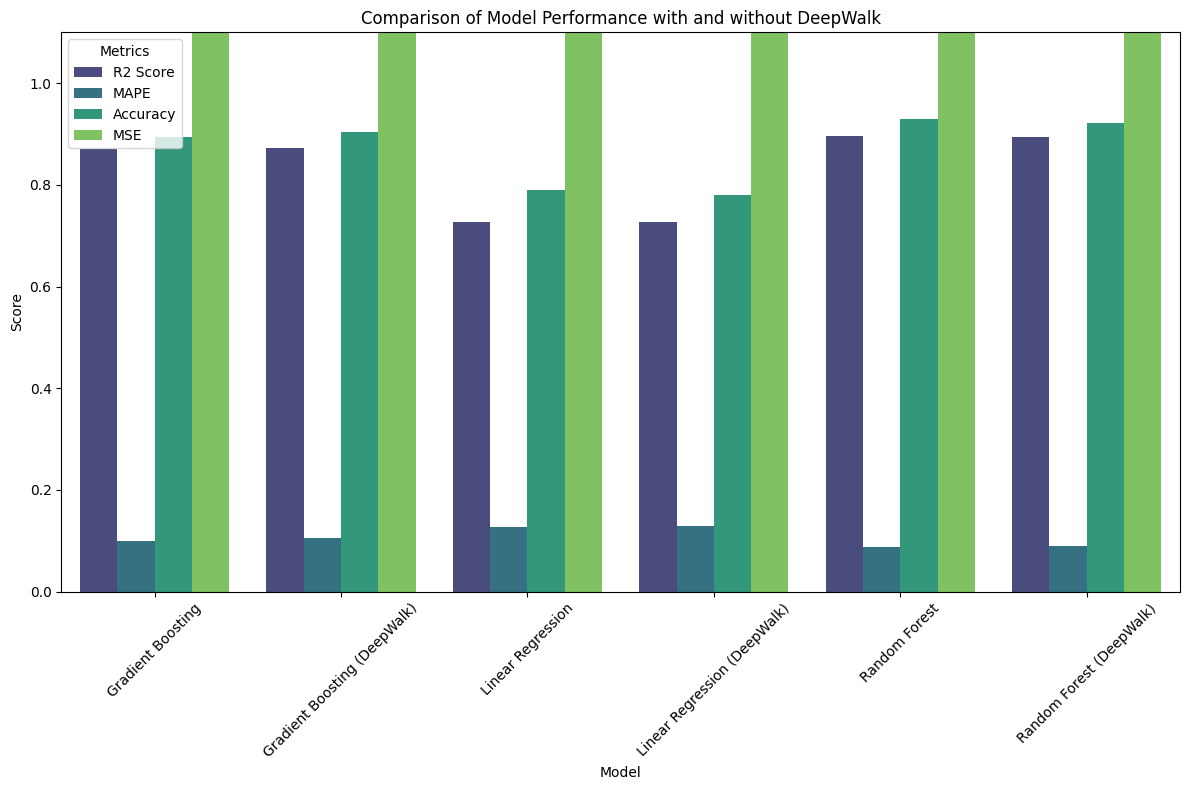

In [51]:
import seaborn as sns

# import matplotlib
# # Choose a suitable backend
# # Uncomment the line that suits your environment
# matplotlib.use('TkAgg')  # For standard Python scripts
# # matplotlib.use('Qt5Agg')  # For PyQT applications
# # matplotlib.use('MacOSX')  # For macOS systems
# 
import matplotlib.pyplot as plt  
# Reshape the DataFrame for Seaborn  
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')  

# Create a bar plot  
plt.figure(figsize=(12, 8))  
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='viridis')  

# Adding titles and labels  
plt.title('Comparison of Model Performance with and without DeepWalk')  
plt.xticks(rotation=45)  
plt.ylabel('Score')  
plt.ylim(0, 1.1)  # Adjust according to your data range  
plt.legend(title='Metrics')  
plt.tight_layout()  
plt.show() 

DataFrame columns: Index(['Model', 'R2 Score', 'MAPE', 'Accuracy', 'MSE'], dtype='object')


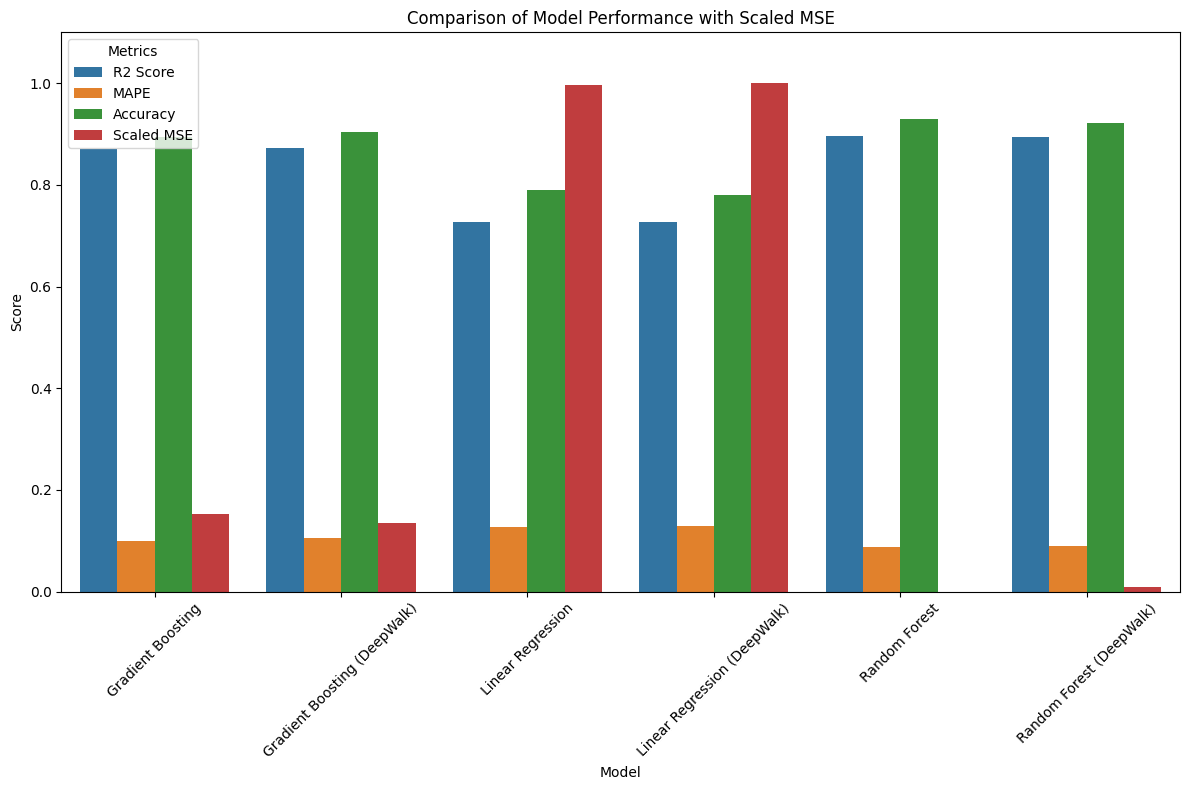

In [52]:
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  

# Check the columns of your DataFrame  
print("DataFrame columns:", results_df.columns)  

# Ensure your DataFrame contains the expected column names before proceeding  
required_columns = ['Model', 'MSE', 'R2 Score', 'MAPE', 'Accuracy']  
if all(col in results_df.columns for col in required_columns):  
    # Scale MSE to [0, 1]  
    mse_min = results_df['MSE'].min()  
    mse_max = results_df['MSE'].max()  
    results_df['Scaled MSE'] = (results_df['MSE'] - mse_min) / (mse_max - mse_min)  

    # Select the metrics to plot, including the scaled MSE  
    metrics_to_plot = ['R2 Score', 'MAPE', 'Accuracy', 'Scaled MSE']  
    results_filtered = results_df[['Model'] + metrics_to_plot]  

    # Reshape the DataFrame for Seaborn  
    results_melted = results_filtered.melt(id_vars='Model', var_name='Metric', value_name='Score')  

    # Create a line plot  
    plt.figure(figsize=(12, 8))  
    sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')  
    # sns.lineplot(data=results_melted, x='Model', y='Score', hue='Metric', marker='o', markersize=8)  

    # Adding titles and labels  
    plt.title('Comparison of Model Performance with Scaled MSE')  
    plt.xticks(rotation=45)  
    plt.ylabel('Score')  
    plt.ylim(0, 1.1)  # Adjust based on your score range  
    plt.legend(title='Metrics')  
    plt.tight_layout()  
    plt.show()  
else:  
    print("Missing required columns in the DataFrame!")

DataFrame columns: Index(['Model', 'R2 Score', 'MAPE', 'Accuracy', 'MSE', 'Scaled MSE'], dtype='object')


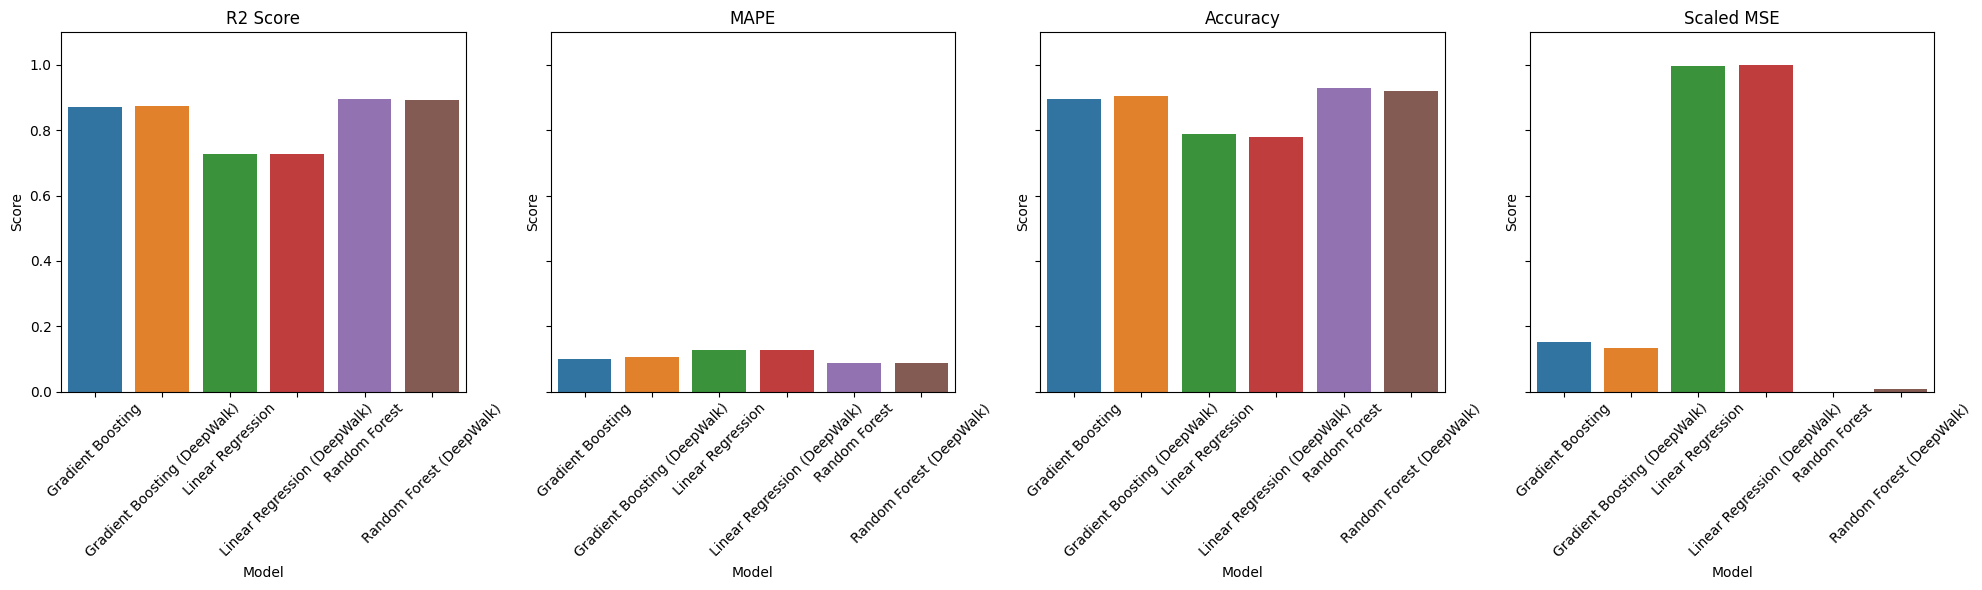

In [53]:
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  

# Check the columns of your DataFrame  
print("DataFrame columns:", results_df.columns)  

# Ensure your DataFrame contains the expected column names before proceeding  
required_columns = ['Model', 'MSE', 'R2 Score', 'MAPE', 'Accuracy']  
if all(col in results_df.columns for col in required_columns):  
    # Scale MSE to [0, 1]  
    mse_min = results_df['MSE'].min()  
    mse_max = results_df['MSE'].max()  
    results_df['Scaled MSE'] = (results_df['MSE'] - mse_min) / (mse_max - mse_min)  

    # Select the metrics to plot, including the scaled MSE  
    metrics_to_plot = ['R2 Score', 'MAPE', 'Accuracy', 'Scaled MSE']  
    results_filtered = results_df[['Model'] + metrics_to_plot]  

    # Reshape the DataFrame for Seaborn  
    results_melted = results_filtered.melt(id_vars='Model', var_name='Metric', value_name='Score')  

    # Create subplots  
    num_metrics = len(metrics_to_plot)  
    fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(20, 6), sharey=True)  

    # Iterate over each metric and create a bar plot  
    for i, metric in enumerate(metrics_to_plot):  
        ax = axes[i]  
        sns.barplot(data=results_melted[results_melted['Metric'] == metric],  
                     x='Model', y='Score', ax=ax)  
        ax.set_title(metric)  
        ax.set_ylim(0, 1.1)  # Adjust based on your score range  
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x labels for better visibility  
        if i == 0:  # Only label y-axis for the first subplot  
            ax.set_ylabel('Score')  

    plt.subplots_adjust(wspace=0.3)  # Adjust spacing between subplots  
    plt.tight_layout()  
    plt.show()  
else:  
    print("Missing required columns in the DataFrame!")

DataFrame columns: Index(['Model', 'R2 Score', 'MAPE', 'Accuracy', 'MSE', 'Scaled MSE'], dtype='object')


C:\Users\m.amintoosi\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\m.amintoosi\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\m.amintoosi\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\m.amintoosi\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pan

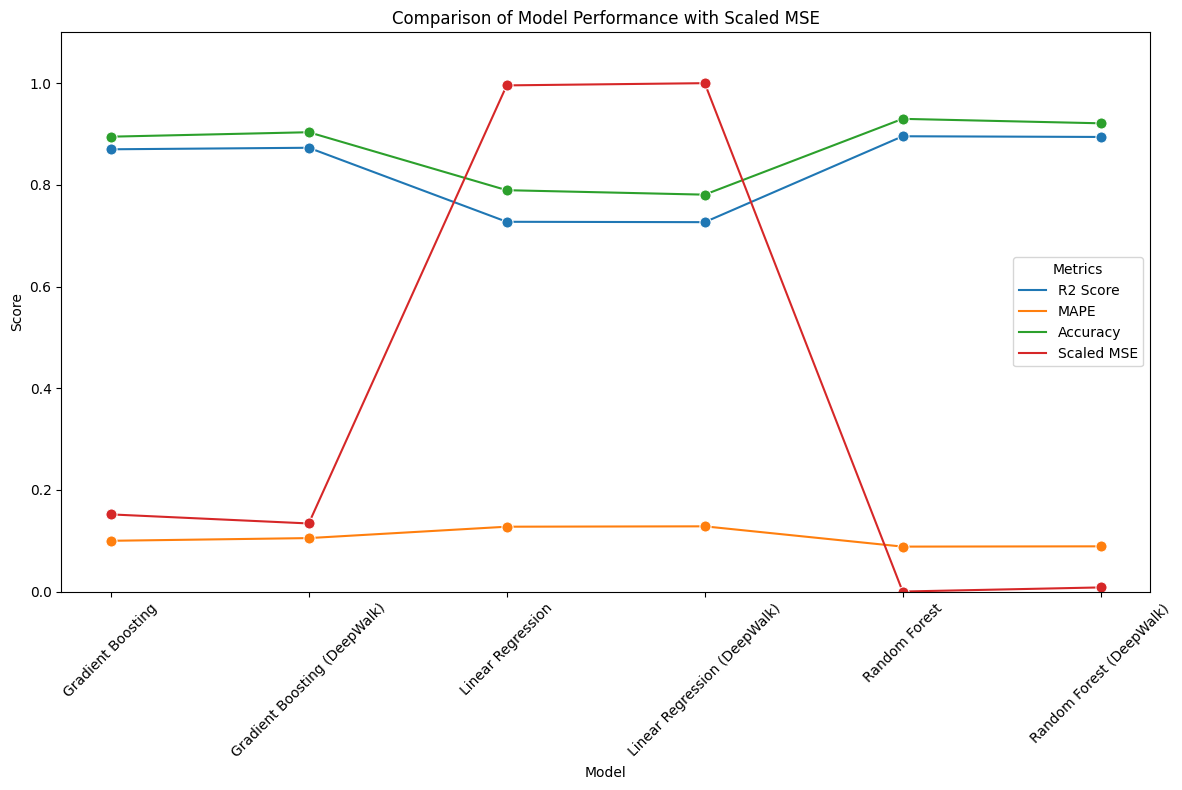

In [55]:
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  

# Check the columns of your DataFrame  
print("DataFrame columns:", results_df.columns)  

# Ensure your DataFrame contains the expected column names before proceeding  
required_columns = ['Model', 'MSE', 'R2 Score', 'MAPE', 'Accuracy']  
if all(col in results_df.columns for col in required_columns):  
    # Scale MSE to [0, 1]  
    mse_min = results_df['MSE'].min()  
    mse_max = results_df['MSE'].max()  
    results_df['Scaled MSE'] = (results_df['MSE'] - mse_min) / (mse_max - mse_min)  

    # Select the metrics to plot, including the scaled MSE  
    metrics_to_plot = ['R2 Score', 'MAPE', 'Accuracy', 'Scaled MSE']  
    results_filtered = results_df[['Model'] + metrics_to_plot]  

    # Reshape the DataFrame for Seaborn  
    results_melted = results_filtered.melt(id_vars='Model', var_name='Metric', value_name='Score')  

    # Create a line plot  
    plt.figure(figsize=(12, 8))  
    # sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')  
    sns.lineplot(data=results_melted, x='Model', y='Score', hue='Metric', marker='o', markersize=8)  

    # Adding titles and labels  
    plt.title('Comparison of Model Performance with Scaled MSE')  
    plt.xticks(rotation=45)  
    plt.ylabel('Score')  
    plt.ylim(0, 1.1)  # Adjust based on your score range  
    plt.legend(title='Metrics')  
    plt.tight_layout()  
    plt.show()  
else:  
    print("Missing required columns in the DataFrame!")

In [ ]:
results_df.columns

Index(['Model', 'R2 Score', 'MAPE', 'Accuracy', 'MSE', 'Scaled MSE'], dtype='object')

In [56]:
import pandas as pd  

# Load results from the Excel file  
results_df = pd.read_excel('results/model_results.xlsx')  

# Generate LaTeX longtable format  
latex_table = results_df.to_latex(index=False, escape=False, longtable=True, caption='Results of Regression Models', label='tab:regression_results')  

# Specify the filename for the LaTeX table  
latex_filename = 'results/results_table.tex'  

# Save the LaTeX table to a file  
with open(latex_filename, 'w') as f:  
    f.write(latex_table)  

print(f"LaTeX table has been saved to {latex_filename}")

LaTeX table has been saved to results/results_table.tex


In [57]:
import matplotlib.pyplot as plt  

# Set up the environment for PGF  
import matplotlib as mpl  
mpl.use('pgf')  

# You can set font and other parameters as needed  
mpl.rcParams.update({  
    "pgf.texsystem": "pdflatex",  
    "font.family": "serif",  
    "font.serif": [],  
    "font.size": 12,  
    "pgf.rcfonts": False,  
})  

# Create and save plots  
def plot_results(results_df):  
    metrics = ['R2 Score', 'MAPE', 'Accuracy', 'MSE']  
    models = results_df['Model']  

    for metric in metrics:  
        plt.figure(figsize=(10, 5))  
        plt.bar(models, results_df[metric], color='skyblue')  
        plt.title(f'{metric} of Regression Models')  
        plt.xticks(rotation=45)  
        plt.ylabel(metric)  
        plt.tight_layout()  
        plt.savefig(f'results/{metric.replace(" ", "_").lower()}.pgf')  # Save as PGF files  
        plt.close()  

plot_results(results_df)